In [1]:
import os 

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')


Project path set to: c:\Github\ode-biomarker-project


In [2]:
import toolkit as tl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set the seaborn theme
sns.set_theme(style="whitegrid")
# set to talk 
sns.set_context("talk")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


In [4]:
import DataFunctions as utils 

target_variable = "AUC"

data_df = utils.create_joint_dataset_from_proteome_gdsc("Palbociclib", joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

In [5]:
### Record SHAP values for network stat features

tool = tl.Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                tl.impute_with_network_stat_selection,
                (nth_degree_neighbours, 2, 100))

tool.add_model('ElasticNet',
            'ElasticNet', 
            {'alpha': 0.005})

rng_list = np.random.randint(0, 100000, 5)
tool.set_rng_list(rng_list)

shap_df = tool.run_all(n_jobs=2, verbose=True)

shap_contribs = tl.get_mean_contribution(shap_df, 'network_stat')

### All models ran


In [6]:
shap_contribs.head()

,mean_shap_values,count
feature_names,,
P26447;S10A4_HUMAN,0.010671,2
P06400;RB_HUMAN,0.007713,5
P13861;KAP2_HUMAN,0.006350,5
P06756;ITAV_HUMAN,0.005558,5
P25098;ARBK1_HUMAN,0.004545,5


In [10]:
# modify the column name 'mean_shap_values' to 'fold_1'

shap_contribs = shap_contribs.rename(columns={'mean_shap_values': 'fold_1'})

In [11]:
shap_contribs.head()

,fold_1,count
feature_names,,
P26447;S10A4_HUMAN,0.010671,2
P06400;RB_HUMAN,0.007713,5
P13861;KAP2_HUMAN,0.006350,5
P06756;ITAV_HUMAN,0.005558,5
P25098;ARBK1_HUMAN,0.004545,5


In [12]:
# remove the column 'count' 

shap_contribs = shap_contribs.drop(columns=['count'])

In [13]:
shap_contribs.head()


,fold_1
feature_names,
P26447;S10A4_HUMAN,0.010671
P06400;RB_HUMAN,0.007713
P13861;KAP2_HUMAN,0.006350
P06756;ITAV_HUMAN,0.005558
P25098;ARBK1_HUMAN,0.004545


In [15]:
shap_contribs_2 = shap_contribs.copy()
shap_contribs_2.head()

,fold_1
feature_names,
P26447;S10A4_HUMAN,0.010671
P06400;RB_HUMAN,0.007713
P13861;KAP2_HUMAN,0.006350
P06756;ITAV_HUMAN,0.005558
P25098;ARBK1_HUMAN,0.004545


In [19]:
shap_contribs_2 = shap_contribs_2.rename(columns={'fold_1': 'fold_2'})


In [20]:
shap_contribs_2.head()

,fold_2
feature_names,
P26447;S10A4_HUMAN,0.010671
P06400;RB_HUMAN,0.007713
P13861;KAP2_HUMAN,0.006350
P06756;ITAV_HUMAN,0.005558
P25098;ARBK1_HUMAN,0.004545


In [21]:
# combine the two dataframes

shap_contribs_all = pd.concat([shap_contribs, shap_contribs_2], axis=1)

shap_contribs_all.head()

,fold_1,fold_2
feature_names,,
P26447;S10A4_HUMAN,0.010671,0.010671
P06400;RB_HUMAN,0.007713,0.007713
P13861;KAP2_HUMAN,0.006350,0.006350
P06756;ITAV_HUMAN,0.005558,0.005558
P25098;ARBK1_HUMAN,0.004545,0.004545


In [22]:
shap_contribs_3 = shap_contribs.copy()
shap_contribs_3 = shap_contribs_3.rename(columns={'fold_1': 'fold_3'})

shap_contribs_3.head()

,fold_3
feature_names,
P26447;S10A4_HUMAN,0.010671
P06400;RB_HUMAN,0.007713
P13861;KAP2_HUMAN,0.006350
P06756;ITAV_HUMAN,0.005558
P25098;ARBK1_HUMAN,0.004545


In [26]:
# drop a random row in shap_contribs_3

shap_contribs_3 = shap_contribs_3.drop(shap_contribs_3.sample().index)

shap_contribs_3.head()

,fold_3
feature_names,
P26447;S10A4_HUMAN,0.010671
P06400;RB_HUMAN,0.007713
P13861;KAP2_HUMAN,0.006350
P06756;ITAV_HUMAN,0.005558
P25098;ARBK1_HUMAN,0.004545


In [27]:
# combine the two dataframes

shap_contribs_all = pd.concat([shap_contribs_all, shap_contribs_3], axis=1)

shap_contribs_all.head()

,fold_1,fold_2,fold_3,fold_3,fold_3
feature_names,,,,,
P26447;S10A4_HUMAN,0.010671,0.010671,0.010671,0.010671,0.010671
P06400;RB_HUMAN,0.007713,0.007713,0.007713,0.007713,0.007713
P13861;KAP2_HUMAN,0.006350,0.006350,0.006350,0.006350,0.006350
P06756;ITAV_HUMAN,0.005558,0.005558,0.005558,0.005558,0.005558
P25098;ARBK1_HUMAN,0.004545,0.004545,0.004545,0.004545,0.004545


In [31]:
rng_list, total_df = tool.run_until_consensus('network_stat', n_jobs=1, verbose=True, max_iter=10)

current_contrib: ['P26447;S10A4_HUMAN', 'P42771;CDN2A_HUMAN', 'P13861;KAP2_HUMAN', 'P06400;RB_HUMAN', 'Q9Y4B6;DCAF1_HUMAN']
current iteration: 2 current_tol: 0.370374, abs_diff: 0.024532, abs_prev: 0.066236, corr: 0.583205
current_contrib: ['P26447;S10A4_HUMAN', 'P42771;CDN2A_HUMAN', 'P06400;RB_HUMAN', 'P13861;KAP2_HUMAN', 'Q9Y4B6;DCAF1_HUMAN']
current iteration: 3 current_tol: 0.163850, abs_diff: 0.013941, abs_prev: 0.085087, corr: 0.493118
current_contrib: ['P26447;S10A4_HUMAN', 'P06400;RB_HUMAN', 'P42771;CDN2A_HUMAN', 'P13861;KAP2_HUMAN', 'P18031;PTN1_HUMAN']
current iteration: 4 current_tol: 0.170825, abs_diff: 0.014729, abs_prev: 0.086224, corr: 0.205816
current_contrib: ['P26447;S10A4_HUMAN', 'P06400;RB_HUMAN', 'P42771;CDN2A_HUMAN', 'P13861;KAP2_HUMAN', 'P18031;PTN1_HUMAN']
current iteration: 5 current_tol: 0.073380, abs_diff: 0.006873, abs_prev: 0.093669, corr: 0.459341
current_contrib: ['P26447;S10A4_HUMAN', 'P06400;RB_HUMAN', 'P42771;CDN2A_HUMAN', 'P13861;KAP2_HUMAN', 'P18031;

In [50]:
data = []

for i in range(len(rng_list)):
    mean_contribution = tl.get_mean_contribution(total_df.iloc[:i+1], 'network_stat', strict_mean=0.75)
    mean_contribution = mean_contribution.rename(columns={'mean_shap_values': f'iter{i+1}'})
    mean_contribution = mean_contribution.drop(columns=['count'])
    data.append(mean_contribution)

shap_contribs_all = pd.concat(data, axis=1)

shap_contribs_all.head()


,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10
feature_names,,,,,,,,,,
P06400;RB_HUMAN,0.007551,0.005461,0.006429,0.007592,0.007615,0.007781,0.007666,0.007701,0.007788,0.007733
P32519;ELF1_HUMAN,0.005113,0.003099,0.002719,0.002728,0.002771,0.002921,0.003187,0.003011,0.002886,0.002894
P13861;KAP2_HUMAN,0.004500,0.005831,0.005999,0.005488,0.005449,0.005717,0.005870,0.005557,0.005610,0.005696
P05556;ITB1_HUMAN,0.003496,0.003061,0.003061,0.003081,0.003081,0.003081,0.003081,0.003447,0.003447,0.003447
P18031;PTN1_HUMAN,0.003436,0.002918,0.003849,0.004704,0.004876,0.005109,0.005083,0.005295,0.005077,0.005112


In [59]:
# sort shap_contribs_all descending order by last column

shap_contribs_all_sorted = shap_contribs_all.sort_values(by=shap_contribs_all.columns[-1], ascending=False)

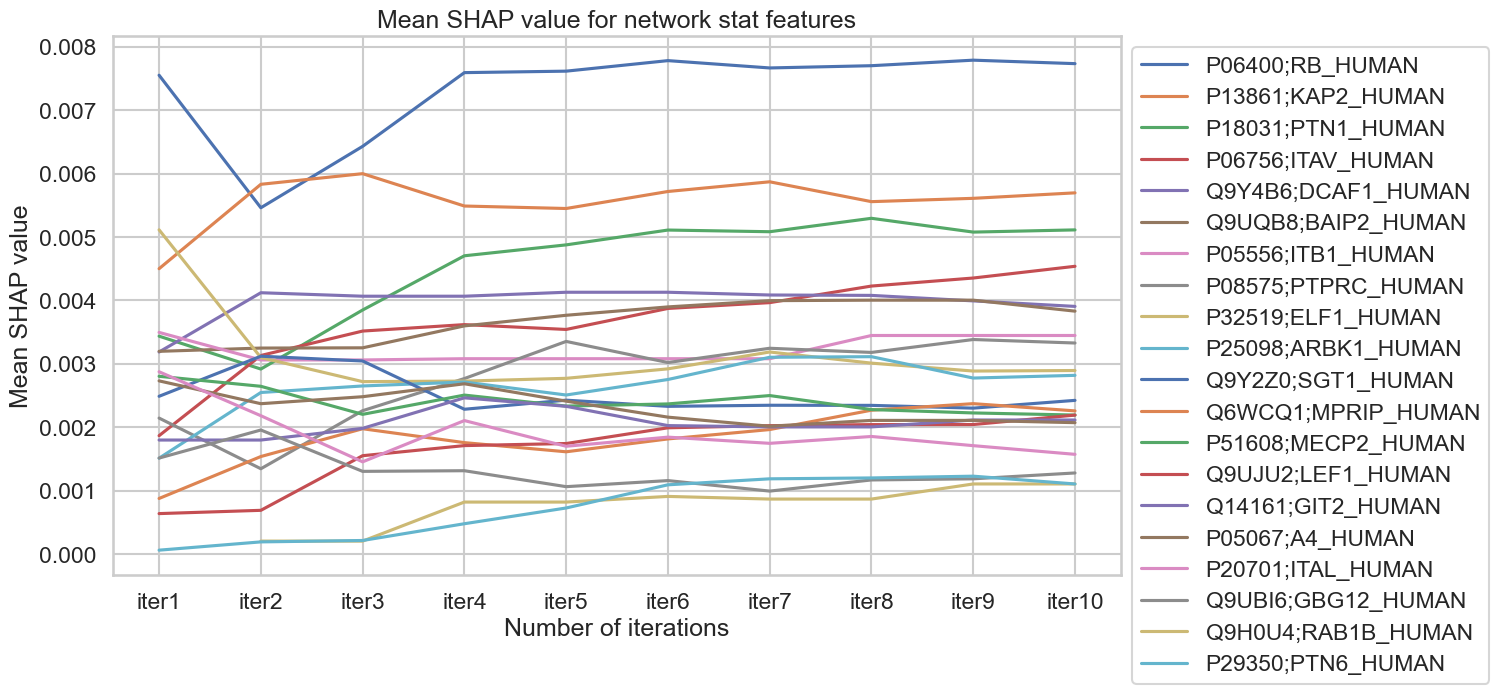

In [66]:
# plot each row as a line plot

fig, ax = plt.subplots(figsize=(13, 7))

for i in range(20):
    ax.plot(shap_contribs_all_sorted.iloc[i, :])
    
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Mean SHAP value')
ax.set_title('Mean SHAP value for network stat features')
ax.legend(shap_contribs_all_sorted.index, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()